In [1]:
import time
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.precision", 3)
np.set_printoptions(precision=3)
%matplotlib inline

In [2]:
from math import *
from sklearn.metrics import *

import statsmodels.api as sm
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lars
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [3]:
import pylab 
import joblib
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [4]:
df_wid = pd.read_csv('widening.csv')
df_nar = pd.read_csv('narrowing.csv')
df_wid.drop(['Unnamed: 0','ColTime'],axis=1,inplace=True)
df_nar.drop(['Unnamed: 0','ColTime'],axis=1,inplace=True)
df_wid.head()

,Acc,AbsSpd,S,DeltaV,Type-Car,Type-TW,SLType-Car,SLType-TW,Category-Left,Category-NoLead,Category-Right
0,0.754,12.549,11.503,0.092,0,1,0,1,0,1,0
1,2.657,11.684,6.135,4.808,0,1,0,1,0,1,0
2,1.669,12.311,8.152,0.389,0,1,0,1,0,1,0
3,1.258,12.986,12.444,2.004,0,1,0,1,0,1,0
4,1.427,12.165,5.068,1.973,0,1,0,1,0,1,0


In [5]:
df_bin = df_wid.copy()
bins_interval = {"AbsSpd":0.1}
bins_feat = ['AbsSpd']
for col in bins_feat:
    bins = np.arange(df_bin[col].min(),df_bin[col].max()+bins_interval[col],bins_interval[col])
    def col_bins(x):
        for i in range(len(bins)):
            if x <= bins[i]:
                return i
    
    df_bin[f'{col}_bins'] = df_bin[col].apply(col_bins)
    #df_bin[f'{col}_mean'] = df_bin.groupby(f'{col}_bins')[col].transform('mean')

df_Wbin = df_bin.groupby('AbsSpd_bins').mean().reset_index()
print(df_Wbin.shape)
df_Wbin.tail()

(144, 12)


,AbsSpd_bins,Acc,AbsSpd,S,DeltaV,Type-Car,Type-TW,SLType-Car,SLType-TW,Category-Left,Category-NoLead,Category-Right
139,187,0.041,18.869,26.139,0.511,0.0,1.0,0.0,1.0,0.0,1.0,0.0
140,190,0.426,19.137,16.099,2.156,1.0,0.0,0.0,1.0,0.0,1.0,0.0
141,194,0.092,19.632,9.864,0.180,0.0,1.0,0.0,1.0,0.0,1.0,0.0
142,203,0.732,20.518,4.117,1.298,0.0,1.0,0.0,1.0,0.0,1.0,0.0
143,207,0.086,20.890,15.383,0.002,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [6]:
df_bin = df_nar.copy()
bins_interval = {"AbsSpd":0.1}
bins_feat = ['AbsSpd']
for col in bins_feat:
    bins = np.arange(df_bin[col].min(),df_bin[col].max()+bins_interval[col],bins_interval[col])
    def col_bins(x):
        for i in range(len(bins)):
            if x <= bins[i]:
                return i
    
    df_bin[f'{col}_bins'] = df_bin[col].apply(col_bins)
    #df_bin[f'{col}_mean'] = df_bin.groupby(f'{col}_bins')[col].transform('mean')

df_Nbin = df_bin.groupby('AbsSpd_bins').mean().reset_index()
print(df_Nbin.shape)
df_Nbin.tail()

(142, 12)


,AbsSpd_bins,Acc,AbsSpd,S,DeltaV,Type-Car,Type-TW,SLType-Car,SLType-TW,Category-Left,Category-NoLead,Category-Right
137,175,-3.894,20.519,15.710,-5.976,0.0,1.0,0.5,0.5,0.0,1.0,0.0
138,176,-1.572,20.645,14.163,-1.579,0.0,1.0,0.0,1.0,0.0,1.0,0.0
139,179,-2.665,20.926,11.294,-6.806,0.0,1.0,0.0,1.0,0.0,0.5,0.5
140,185,-2.429,21.519,27.785,-4.950,0.0,1.0,0.0,1.0,0.0,1.0,0.0
141,197,-2.638,22.725,27.889,-10.770,0.0,1.0,0.0,1.0,0.0,1.0,0.0


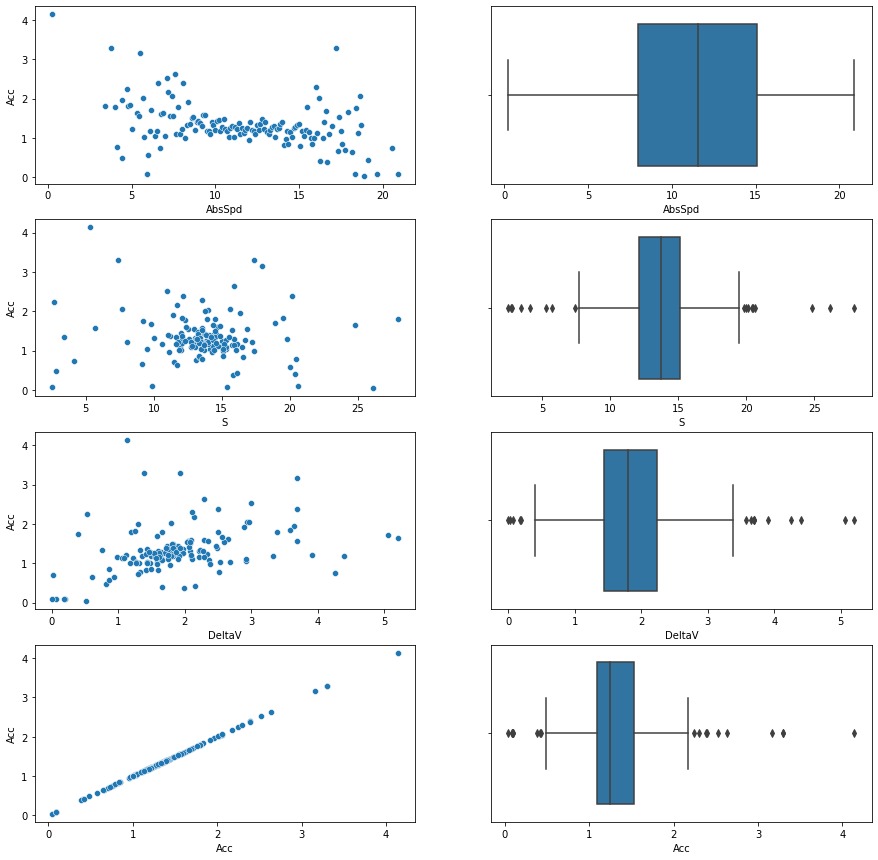

In [7]:
col_list = ['AbsSpd','S','DeltaV','Acc']
fig, axes = plt.subplots(4,2, figsize=(15,15))

for i in range(len(col_list)):
    sns.boxplot    (ax=axes[i,1], data = df_Wbin, x = col_list[i])
    sns.scatterplot(ax=axes[i,0], data = df_Wbin, x = col_list[i], y = 'Acc')

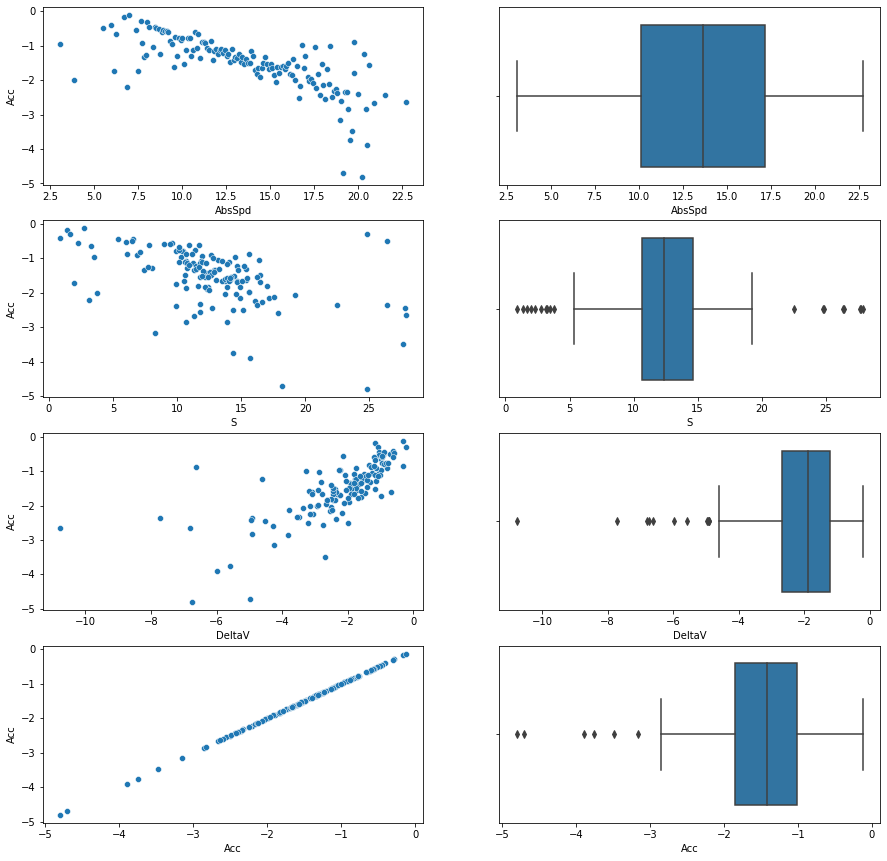

In [8]:
col_list = ['AbsSpd','S','DeltaV','Acc']
fig, axes = plt.subplots(4,2, figsize=(15,15))

for i in range(len(col_list)):
    sns.boxplot    (ax=axes[i,1], data = df_Nbin, x = col_list[i])
    sns.scatterplot(ax=axes[i,0], data = df_Nbin, x = col_list[i], y = 'Acc')

## Model building Accleration Gap Widening

In [9]:
X = df_Wbin.drop(['Acc','AbsSpd_bins'],axis=1)
y = df_Wbin['Acc']

attributes = X.columns
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = attributes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=35) ## 55 

xgbr = XGBRegressor(colsample_bytree = 0.8,learning_rate =0.1,max_depth= 15,
        min_child_weight =15,n_estimators = 50,subsample = 0.80,random_state=15)

xgbr.fit(X_train,y_train,early_stopping_rounds=20, eval_set=[(X_test, y_test)], verbose=False)


svr = SVR(kernel='linear')
svr.fit(X_train,y_train)

rf = RandomForestRegressor(random_state=10,n_estimators = 50,
                          max_depth=15, min_samples_leaf=10,min_samples_split=10)
rf.fit(X_train,y_train)

lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

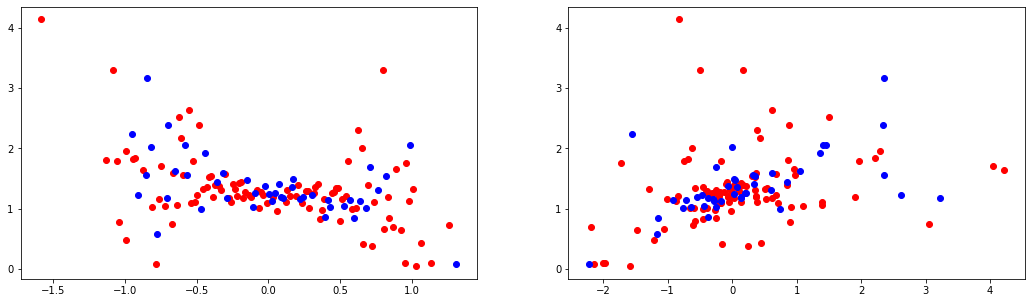

In [10]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.scatter(X_train['AbsSpd'],y_train,c='r')
plt.scatter(X_test['AbsSpd'],y_test,c='b')

plt.subplot(1,2,2)
plt.scatter(X_train['DeltaV'],y_train,c='r')
plt.scatter(X_test['DeltaV'],y_test,c='b')
plt.show()

## Saving the models

In [11]:
joblib.dump(lr,   'lr_bin_wid.pkl')
joblib.dump(svr,  'svr_bin_wid.pkl')
joblib.dump(rf,   'rf_bin_wid.pkl')
joblib.dump(xgbr, 'xgbr_bin_wid.pkl')

['xgbr_bin_wid.pkl']

In [12]:
xgbr_pred   = xgbr.predict(X_test)
rf_pred     = rf.predict(X_test)
svr_pred    = svr.predict(X_test)
lr_pred     = lr.predict(X_test)

xgbr_train  = xgbr.predict(X_train)
rf_train    = rf.predict(X_train)
svr_train   = svr.predict(X_train)
lr_train    = lr.predict(X_train)


xgbr_R2_T   = xgbr.score(X_train,y_train)
xgbr_R2     = xgbr.score(X_test,y_test)
xgbr_RMSE   = mean_squared_error(y_test,xgbr_pred,squared=False)
xgbr_RMSE_T =mean_squared_error(y_train,xgbr_train,squared=False)
xgbr_MAE    = mean_absolute_error(y_test,xgbr_pred)
xgbr_MAE_T  = mean_absolute_error(y_train,xgbr_train)


rf_R2_T     = rf.score(X_train,y_train)
rf_R2       = rf.score(X_test,y_test)
rf_RMSE     = mean_squared_error(y_test,rf_pred,squared=False)
rf_RMSE_T   = mean_squared_error(y_train,rf_train,squared=False)
rf_MAE      = mean_absolute_error(y_test,rf_pred)
rf_MAE_T    = mean_absolute_error(y_train,rf_train)

svr_R2_T    = svr.score(X_train,y_train)
svr_R2      = svr.score(X_test,y_test)
svr_RMSE    = mean_squared_error(y_test,svr_pred,squared=False)
svr_RMSE_T  = mean_squared_error(y_train,svr_train,squared=False)
svr_MAE     = mean_absolute_error(y_test,svr_pred)
svr_MAE_T   = mean_absolute_error(y_train,svr_train)

lr_R2_T     = lr.score(X_train,y_train)
lr_R2       = lr.score(X_test,y_test)
lr_RMSE     = mean_squared_error(y_test,lr_pred,squared=False)
lr_RMSE_T   = mean_squared_error(y_train,lr_train,squared=False)
lr_MAE      = mean_absolute_error(y_test,lr_pred)
lr_MAE_T    = mean_absolute_error(y_train,lr_train)

dct = {}
dct['XGBR'] = [xgbr_R2_T,xgbr_R2,xgbr_RMSE_T,xgbr_RMSE,xgbr_MAE_T,xgbr_MAE]
dct['RF']   = [rf_R2_T,rf_R2,rf_RMSE_T,rf_RMSE,rf_MAE_T,rf_MAE]
dct['SVR']  = [svr_R2_T,svr_R2,svr_RMSE_T,svr_RMSE,svr_MAE_T,svr_MAE]
dct['LR']   = [lr_R2_T,lr_R2,lr_RMSE_T,lr_RMSE,lr_MAE_T,lr_MAE]

df_res = pd.DataFrame(dct).T
df_res.columns = ['Train_R2','Test_R2','Train_RMSE','Test_RMSE','Train_MAE','Test_MAE']
# print(df_res)

dct1 = {}
dct1['XGBR'] = list(xgbr.feature_importances_)
dct1['RF']   = list(rf.feature_importances_)
dct1['SVR']  = list(svr.coef_[0])
dct1['LR']   = list(lr.coef_)

df_fi = pd.DataFrame(dct1).T
df_fi.columns = X.columns
df_res

,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE
XGBR,0.389,0.476,0.487,0.362,0.294,0.262
RF,0.256,0.329,0.538,0.409,0.338,0.286
SVR,0.251,-0.014,0.540,0.503,0.328,0.335
LR,0.350,0.209,0.503,0.444,0.338,0.312


In [13]:
df_fi.T

,XGBR,RF,SVR,LR
AbsSpd,0.177,0.378,-0.043,-0.221
S,0.115,0.106,0.006,-0.108
DeltaV,0.115,0.183,0.111,0.126
Type-Car,0.106,0.064,-0.118,0.027
Type-TW,0.099,0.045,-0.123,0.113
SLType-Car,0.063,0.016,-0.302,-0.296
SLType-TW,0.071,0.026,-0.389,-0.399
Category-Left,0.110,0.073,0.158,0.180
Category-NoLead,0.085,0.056,0.231,0.375
Category-Right,0.060,0.053,0.418,0.497


In [14]:
df_wid1 = df_Wbin.copy()
scaler = RobustScaler()
# df_wid1['DeltaV'] = scaler.fit_transform(np.array(df_wid1['DeltaV']).reshape(-1,1))
# df_wid1['S']      = scaler.fit_transform(np.array(df_wid1['S']).reshape(-1,1))
# df_wid1['AbsSpd'] = scaler.fit_transform(np.array(df_wid1['AbsSpd']).reshape(-1,1))

sm_X = df_wid1.drop(['Acc','AbsSpd_bins'],axis=1)
sm_y = df_wid1['Acc']

attributes = sm_X.columns
scaler = RobustScaler()
sm_X = pd.DataFrame(scaler.fit_transform(sm_X))
sm_X.columns = attributes

model = sm.OLS(sm_y, sm_X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    Acc   R-squared (uncentered):                   0.895
Model:                            OLS   Adj. R-squared (uncentered):              0.888
Method:                 Least Squares   F-statistic:                              114.6
Date:                Thu, 29 Jul 2021   Prob (F-statistic):                    1.34e-60
Time:                        12:15:22   Log-Likelihood:                         -96.059
No. Observations:                 144   AIC:                                      212.1
Df Residuals:                     134   BIC:                                      241.8
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

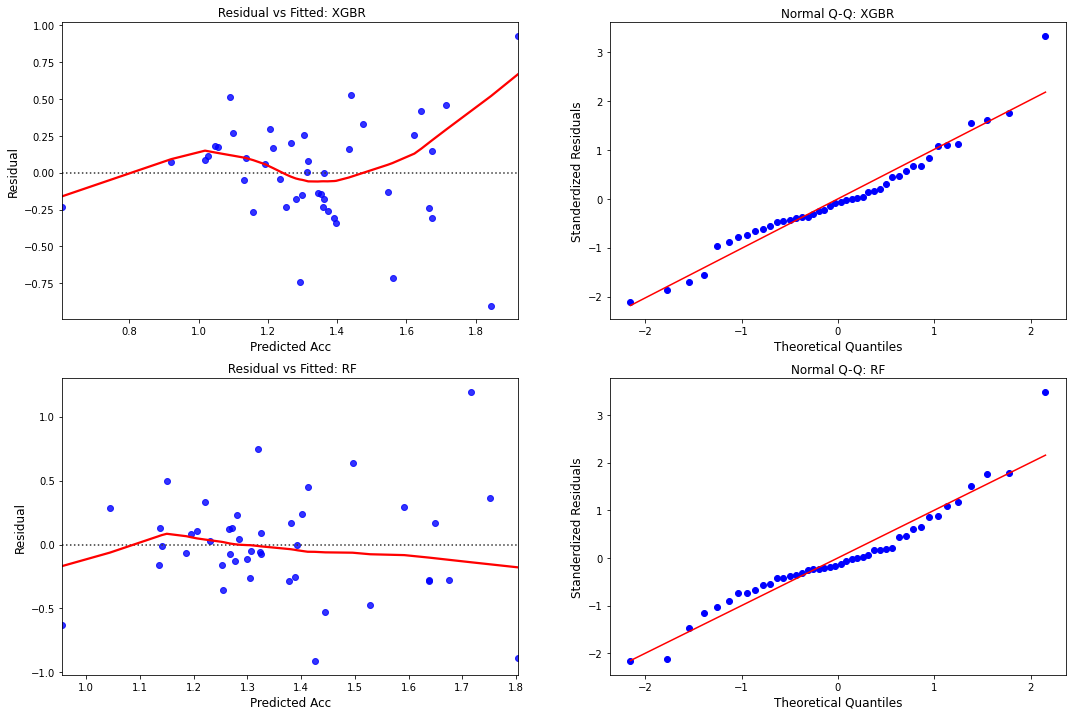

In [15]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
xgbr_res = np.array((y_test-xgbr_pred))
sns.residplot(xgbr_pred,xgbr_res,lowess = True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.ylabel("Residual",size=12)
plt.xlabel("Predicted Acc",size=12)
plt.title(" Residual vs Fitted: XGBR")

plt.subplot(2,2,2)
xgbr_stan = (xgbr_res - np.mean(xgbr_res))/np.std(xgbr_res)
stats.probplot(xgbr_stan, dist="norm", plot=pylab)
plt.title("Normal Q-Q: XGBR")
plt.ylabel("Standerdized Residuals",size=12)
plt.xlabel("Theoretical Quantiles",size=12)


plt.subplot(2,2,3)
rf_res = np.array((y_test-rf_pred))
sns.residplot(rf_pred,rf_res,lowess = True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.ylabel("Residual",size=12)
plt.xlabel("Predicted Acc",size=12)
plt.title(" Residual vs Fitted: RF")

plt.subplot(2,2,4)
rf_stan = (rf_res - np.mean(rf_res))/np.std(rf_res)
stats.probplot(rf_stan, dist="norm", plot=pylab)
plt.title("Normal Q-Q: RF")
plt.ylabel("Standerdized Residuals",size=12)
plt.xlabel("Theoretical Quantiles",size=12)

plt.show()

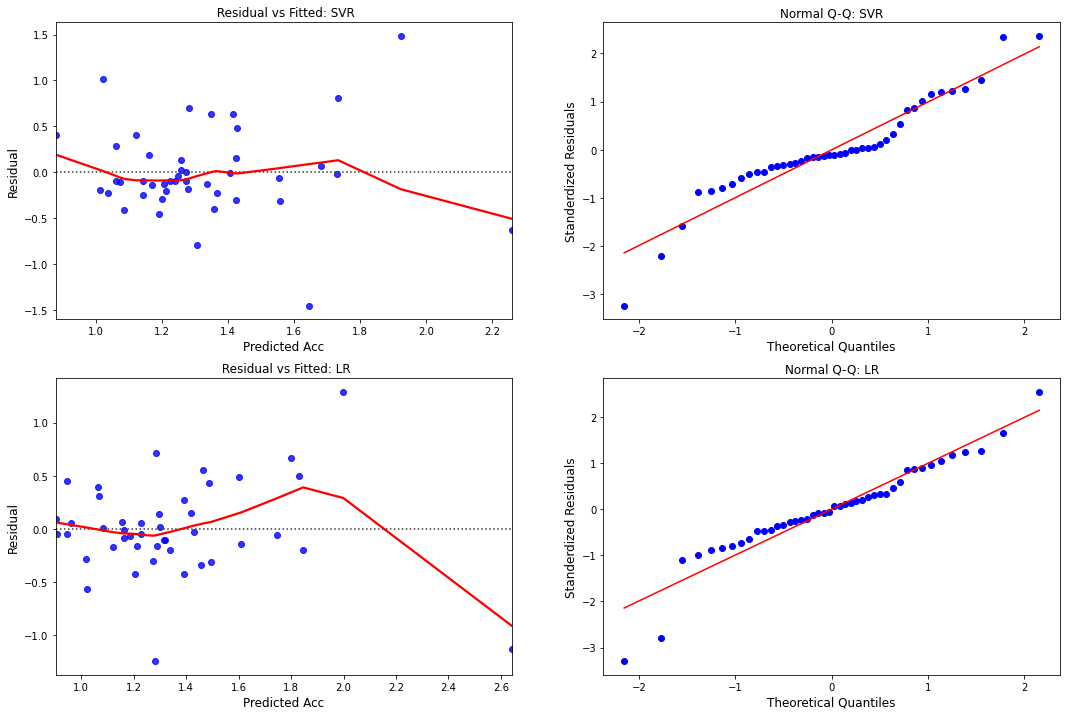

In [16]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
svr_res = np.array((y_test-svr_pred))
sns.residplot(svr_pred,svr_res,lowess = True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.ylabel("Residual",size=12)
plt.xlabel("Predicted Acc",size=12)
plt.title(" Residual vs Fitted: SVR")

plt.subplot(2,2,2)
svr_stan = (svr_res - np.mean(svr_res))/np.std(svr_res)
stats.probplot(svr_stan, dist="norm", plot=pylab)
plt.title("Normal Q-Q: SVR")
plt.ylabel("Standerdized Residuals",size=12)
plt.xlabel("Theoretical Quantiles",size=12)


plt.subplot(2,2,3)
lr_res = np.array((y_test-lr_pred))
sns.residplot(lr_pred,lr_res,lowess = True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.ylabel("Residual",size=12)
plt.xlabel("Predicted Acc",size=12)
plt.title(" Residual vs Fitted: LR")

plt.subplot(2,2,4)
lr_stan = (lr_res - np.mean(lr_res))/np.std(lr_res)
stats.probplot(lr_stan, dist="norm", plot=pylab)
plt.title("Normal Q-Q: LR")
plt.ylabel("Standerdized Residuals",size=12)
plt.xlabel("Theoretical Quantiles",size=12)

plt.show()

## Loading the unbinned models

In [17]:
xgbr = joblib.load('xgbr_unbin_wid.pkl')
rf   = joblib.load('rf_unbin_wid.pkl')
svr  = joblib.load('svr_unbin_wid.pkl')
lr   = joblib.load('lr_unbin_wid.pkl')

xgbr_pred   = xgbr.predict(X_test)
rf_pred     = rf.predict(X_test)
svr_pred    = svr.predict(X_test)
lr_pred     = lr.predict(X_test)

xgbr_train  = xgbr.predict(X_train)
rf_train    = rf.predict(X_train)
svr_train   = svr.predict(X_train)
lr_train    = lr.predict(X_train)


xgbr_R2_T   = xgbr.score(X_train,y_train)
xgbr_R2     = xgbr.score(X_test,y_test)
xgbr_RMSE   = mean_squared_error(y_test,xgbr_pred,squared=False)
xgbr_RMSE_T =mean_squared_error(y_train,xgbr_train,squared=False)
xgbr_MAE    = mean_absolute_error(y_test,xgbr_pred)
xgbr_MAE_T  = mean_absolute_error(y_train,xgbr_train)


rf_R2_T     = rf.score(X_train,y_train)
rf_R2       = rf.score(X_test,y_test)
rf_RMSE     = mean_squared_error(y_test,rf_pred,squared=False)
rf_RMSE_T   = mean_squared_error(y_train,rf_train,squared=False)
rf_MAE      = mean_absolute_error(y_test,rf_pred)
rf_MAE_T    = mean_absolute_error(y_train,rf_train)

svr_R2_T    = svr.score(X_train,y_train)
svr_R2      = svr.score(X_test,y_test)
svr_RMSE    = mean_squared_error(y_test,svr_pred,squared=False)
svr_RMSE_T  = mean_squared_error(y_train,svr_train,squared=False)
svr_MAE     = mean_absolute_error(y_test,svr_pred)
svr_MAE_T   = mean_absolute_error(y_train,svr_train)

lr_R2_T     = lr.score(X_train,y_train)
lr_R2       = lr.score(X_test,y_test)
lr_RMSE     = mean_squared_error(y_test,lr_pred,squared=False)
lr_RMSE_T   = mean_squared_error(y_train,lr_train,squared=False)
lr_MAE      = mean_absolute_error(y_test,lr_pred)
lr_MAE_T    = mean_absolute_error(y_train,lr_train)



dct = {}
dct['XGBR'] = [xgbr_R2_T,xgbr_R2,xgbr_RMSE_T,xgbr_RMSE,xgbr_MAE_T,xgbr_MAE]
dct['RF']   = [rf_R2_T,rf_R2,rf_RMSE_T,rf_RMSE,rf_MAE_T,rf_MAE]
dct['SVR']  = [svr_R2_T,svr_R2,svr_RMSE_T,svr_RMSE,svr_MAE_T,svr_MAE]
dct['LR']   = [lr_R2_T,lr_R2,lr_RMSE_T,lr_RMSE,lr_MAE_T,lr_MAE]

df_res = pd.DataFrame(dct).T
df_res.columns = ['Train_R2','Test_R2','Train_RMSE','Test_RMSE','Train_MAE','Test_MAE']
df_res

,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE
XGBR,-0.242,-0.336,0.695,0.578,0.464,0.416
RF,-0.188,-0.080,0.680,0.519,0.442,0.333
SVR,-0.256,-0.179,0.699,0.543,0.466,0.406
LR,0.085,0.291,0.597,0.421,0.384,0.265


## Model building on Accelaration Gap Narrowing

In [18]:
X = df_Nbin.drop(['Acc','AbsSpd_bins'],axis=1)
y = df_Nbin['Acc']

attributes = X.columns
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = attributes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=150) ## 60, 150

xgbr = XGBRegressor(colsample_bytree = 0.8,learning_rate =0.1,max_depth= 15,
        min_child_weight =15,n_estimators = 50,subsample = 0.80,random_state=15)

xgbr.fit(X_train,y_train,early_stopping_rounds=20, eval_set=[(X_test, y_test)], verbose=False)


svr = SVR(kernel='linear')
svr.fit(X_train,y_train)

rf = RandomForestRegressor(random_state=10,n_estimators = 50,
                          max_depth=15, min_samples_leaf=10,min_samples_split=10)
rf.fit(X_train,y_train)

lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

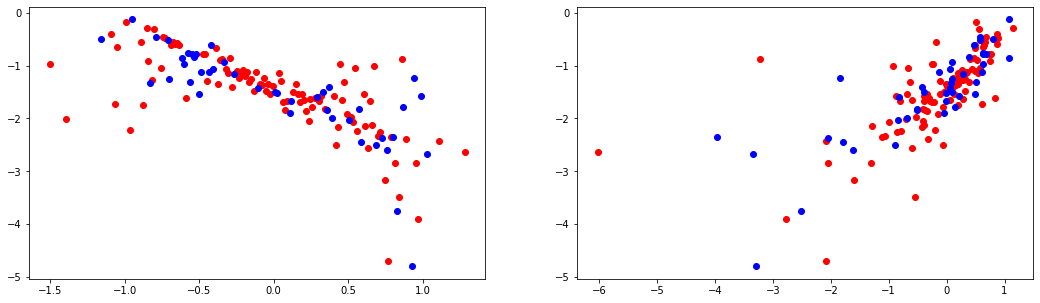

In [19]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.scatter(X_train['AbsSpd'],y_train,c='r')
plt.scatter(X_test['AbsSpd'],y_test,c='b')

plt.subplot(1,2,2)
plt.scatter(X_train['DeltaV'],y_train,c='r')
plt.scatter(X_test['DeltaV'],y_test,c='b')
plt.show()

In [20]:
joblib.dump(lr,   'lr_bin_nar.pkl')
joblib.dump(svr,  'svr_bin_nar.pkl')
joblib.dump(rf,   'rf_bin_nar.pkl')
joblib.dump(xgbr, 'xgbr_bin_nar.pkl')

['xgbr_bin_nar.pkl']

In [21]:
xgbr_pred   = xgbr.predict(X_test)
rf_pred     = rf.predict(X_test)
svr_pred    = svr.predict(X_test)
lr_pred     = lr.predict(X_test)

xgbr_train  = xgbr.predict(X_train)
rf_train    = rf.predict(X_train)
svr_train   = svr.predict(X_train)
lr_train    = lr.predict(X_train)


xgbr_R2_T   = xgbr.score(X_train,y_train)
xgbr_R2     = xgbr.score(X_test,y_test)
xgbr_RMSE   = mean_squared_error(y_test,xgbr_pred,squared=False)
xgbr_RMSE_T =mean_squared_error(y_train,xgbr_train,squared=False)
xgbr_MAE    = mean_absolute_error(y_test,xgbr_pred)
xgbr_MAE_T  = mean_absolute_error(y_train,xgbr_train)


rf_R2_T     = rf.score(X_train,y_train)
rf_R2       = rf.score(X_test,y_test)
rf_RMSE     = mean_squared_error(y_test,rf_pred,squared=False)
rf_RMSE_T   = mean_squared_error(y_train,rf_train,squared=False)
rf_MAE      = mean_absolute_error(y_test,rf_pred)
rf_MAE_T    = mean_absolute_error(y_train,rf_train)

svr_R2_T    = svr.score(X_train,y_train)
svr_R2      = svr.score(X_test,y_test)
svr_RMSE    = mean_squared_error(y_test,svr_pred,squared=False)
svr_RMSE_T  = mean_squared_error(y_train,svr_train,squared=False)
svr_MAE     = mean_absolute_error(y_test,svr_pred)
svr_MAE_T   = mean_absolute_error(y_train,svr_train)

lr_R2_T     = lr.score(X_train,y_train)
lr_R2       = lr.score(X_test,y_test)
lr_RMSE     = mean_squared_error(y_test,lr_pred,squared=False)
lr_RMSE_T   = mean_squared_error(y_train,lr_train,squared=False)
lr_MAE      = mean_absolute_error(y_test,lr_pred)
lr_MAE_T    = mean_absolute_error(y_train,lr_train)



dct = {}
dct['XGBR'] = [xgbr_R2_T,xgbr_R2,xgbr_RMSE_T,xgbr_RMSE,xgbr_MAE_T,xgbr_MAE]
dct['RF']   = [rf_R2_T,rf_R2,rf_RMSE_T,rf_RMSE,rf_MAE_T,rf_MAE]
dct['SVR']  = [svr_R2_T,svr_R2,svr_RMSE_T,svr_RMSE,svr_MAE_T,svr_MAE]
dct['LR']   = [lr_R2_T,lr_R2,lr_RMSE_T,lr_RMSE,lr_MAE_T,lr_MAE]

df_res = pd.DataFrame(dct).T
df_res.columns = ['Train_R2','Test_R2','Train_RMSE','Test_RMSE','Train_MAE','Test_MAE']

dct1 = {}
dct1['XGBR'] = list(xgbr.feature_importances_)
dct1['RF']   = list(rf.feature_importances_)
dct1['SVR']  = list(svr.coef_[0])
dct1['LR']   = list(lr.coef_)

df_fi = pd.DataFrame(dct1).T
df_fi.columns = X.columns
df_res

,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE
XGBR,0.735,0.647,0.395,0.516,0.254,0.353
RF,0.648,0.648,0.455,0.515,0.287,0.325
SVR,0.650,0.692,0.454,0.482,0.287,0.333
LR,0.675,0.654,0.437,0.511,0.294,0.376


In [27]:
df_fi.T

,XGBR,RF,SVR,LR
AbsSpd,0.354,5.119e-01,-0.384,-0.296
S,0.068,1.834e-02,-0.039,-0.088
DeltaV,0.207,3.904e-01,0.293,0.226
Type-Car,0.050,4.631e-03,-0.169,-0.324
Type-TW,0.048,0.000e+00,-0.234,-0.398
SLType-Car,0.032,8.313e-04,0.052,0.107
SLType-TW,0.039,3.028e-03,0.054,0.086
Category-Left,0.068,1.002e-02,-0.402,-0.430
Category-NoLead,0.051,2.005e-02,-0.200,-0.233
Category-Right,0.082,4.079e-02,-0.047,0.048


In [23]:
df_nar1 = df_Nbin.copy()
scaler = RobustScaler()
# df_nar1['DeltaV'] = scaler.fit_transform(np.array(df_nar1['DeltaV']).reshape(-1,1))
# df_nar1['S']      = scaler.fit_transform(np.array(df_nar1['S']).reshape(-1,1))
# df_nar1['AbsSpd'] = scaler.fit_transform(np.array(df_nar1['AbsSpd']).reshape(-1,1))

sm_X = df_nar1.drop(['Acc','AbsSpd_bins'],axis=1)
sm_y = df_nar1['Acc']

attributes = sm_X.columns
scaler = RobustScaler()
sm_X = pd.DataFrame(scaler.fit_transform(sm_X))
sm_X.columns = attributes

model = sm.OLS(sm_y, sm_X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    Acc   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.927
Method:                 Least Squares   F-statistic:                              181.5
Date:                Thu, 29 Jul 2021   Prob (F-statistic):                    5.03e-72
Time:                        12:15:25   Log-Likelihood:                         -87.411
No. Observations:                 142   AIC:                                      194.8
Df Residuals:                     132   BIC:                                      224.4
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

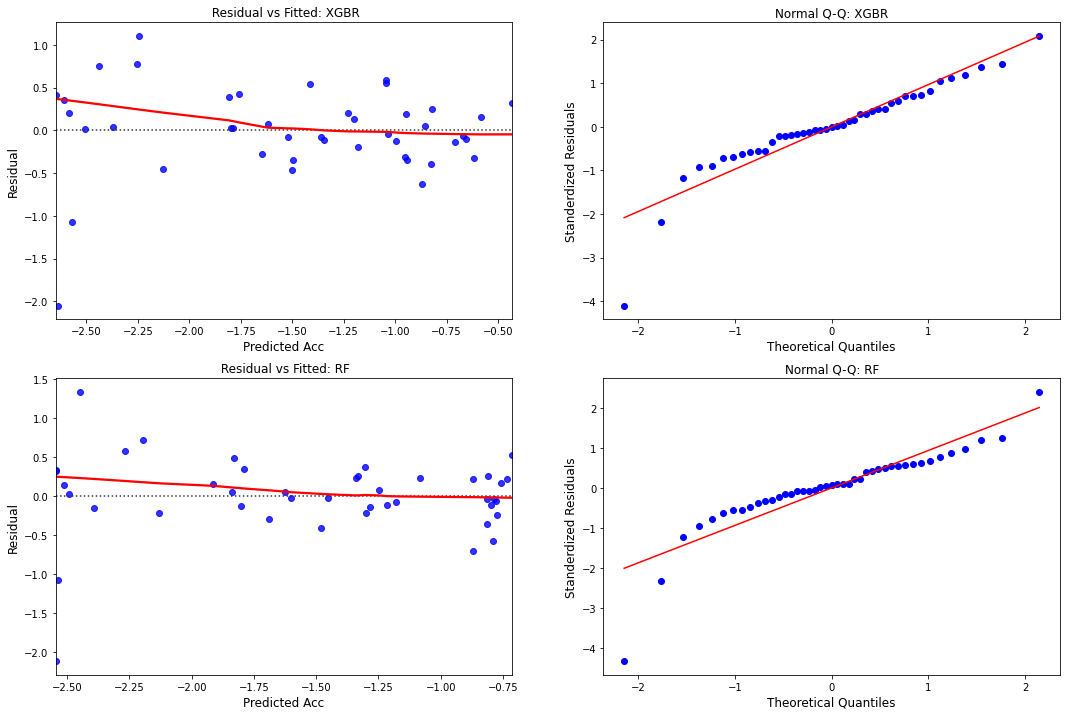

In [24]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
xgbr_res = np.array((y_test-xgbr_pred))
sns.residplot(xgbr_pred,xgbr_res,lowess = True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.ylabel("Residual",size=12)
plt.xlabel("Predicted Acc",size=12)
plt.title(" Residual vs Fitted: XGBR")

plt.subplot(2,2,2)
xgbr_stan = (xgbr_res - np.mean(xgbr_res))/np.std(xgbr_res)
stats.probplot(xgbr_stan, dist="norm", plot=pylab)
plt.title("Normal Q-Q: XGBR")
plt.ylabel("Standerdized Residuals",size=12)
plt.xlabel("Theoretical Quantiles",size=12)


plt.subplot(2,2,3)
rf_res = np.array((y_test-rf_pred))
sns.residplot(rf_pred,rf_res,lowess = True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.ylabel("Residual",size=12)
plt.xlabel("Predicted Acc",size=12)
plt.title(" Residual vs Fitted: RF")

plt.subplot(2,2,4)
rf_stan = (rf_res - np.mean(rf_res))/np.std(rf_res)
stats.probplot(rf_stan, dist="norm", plot=pylab)
plt.title("Normal Q-Q: RF")
plt.ylabel("Standerdized Residuals",size=12)
plt.xlabel("Theoretical Quantiles",size=12)

plt.show()

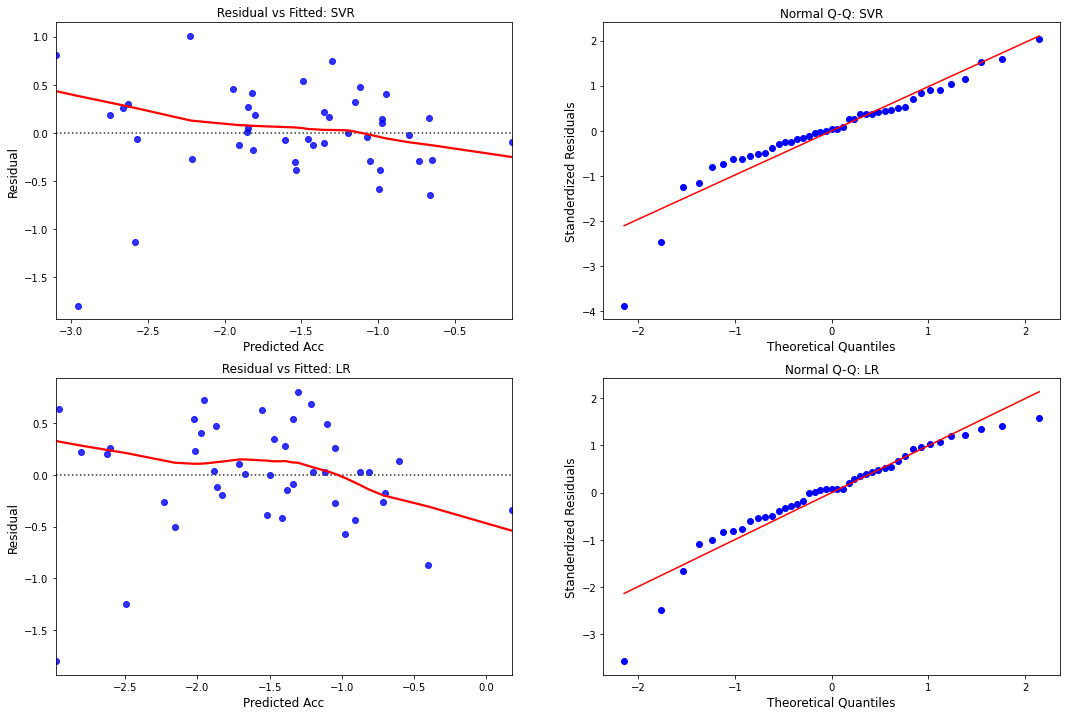

In [25]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
svr_res = np.array((y_test-svr_pred))
sns.residplot(svr_pred,svr_res,lowess = True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.ylabel("Residual",size=12)
plt.xlabel("Predicted Acc",size=12)
plt.title(" Residual vs Fitted: SVR")

plt.subplot(2,2,2)
svr_stan = (svr_res - np.mean(svr_res))/np.std(svr_res)
stats.probplot(svr_stan, dist="norm", plot=pylab)
plt.title("Normal Q-Q: SVR")
plt.ylabel("Standerdized Residuals",size=12)
plt.xlabel("Theoretical Quantiles",size=12)


plt.subplot(2,2,3)
lr_res = np.array((y_test-lr_pred))
sns.residplot(lr_pred,lr_res,lowess = True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.ylabel("Residual",size=12)
plt.xlabel("Predicted Acc",size=12)
plt.title(" Residual vs Fitted: LR")

plt.subplot(2,2,4)
lr_stan = (lr_res - np.mean(lr_res))/np.std(lr_res)
stats.probplot(lr_stan, dist="norm", plot=pylab)
plt.title("Normal Q-Q: LR")
plt.ylabel("Standerdized Residuals",size=12)
plt.xlabel("Theoretical Quantiles",size=12)

plt.show()

In [26]:
xgbr = joblib.load('xgbr_unbin_nar.pkl')
rf   = joblib.load('rf_unbin_nar.pkl')
svr  = joblib.load('svr_unbin_nar.pkl')
lr   = joblib.load('lr_unbin_nar.pkl')

xgbr_pred   = xgbr.predict(X_test)
rf_pred     = rf.predict(X_test)
svr_pred    = svr.predict(X_test)
lr_pred     = lr.predict(X_test)

xgbr_train  = xgbr.predict(X_train)
rf_train    = rf.predict(X_train)
svr_train   = svr.predict(X_train)
lr_train    = lr.predict(X_train)


xgbr_R2_T   = xgbr.score(X_train,y_train)
xgbr_R2     = xgbr.score(X_test,y_test)
xgbr_RMSE   = mean_squared_error(y_test,xgbr_pred,squared=False)
xgbr_RMSE_T =mean_squared_error(y_train,xgbr_train,squared=False)
xgbr_MAE    = mean_absolute_error(y_test,xgbr_pred)
xgbr_MAE_T  = mean_absolute_error(y_train,xgbr_train)


rf_R2_T     = rf.score(X_train,y_train)
rf_R2       = rf.score(X_test,y_test)
rf_RMSE     = mean_squared_error(y_test,rf_pred,squared=False)
rf_RMSE_T   = mean_squared_error(y_train,rf_train,squared=False)
rf_MAE      = mean_absolute_error(y_test,rf_pred)
rf_MAE_T    = mean_absolute_error(y_train,rf_train)

svr_R2_T    = svr.score(X_train,y_train)
svr_R2      = svr.score(X_test,y_test)
svr_RMSE    = mean_squared_error(y_test,svr_pred,squared=False)
svr_RMSE_T  = mean_squared_error(y_train,svr_train,squared=False)
svr_MAE     = mean_absolute_error(y_test,svr_pred)
svr_MAE_T   = mean_absolute_error(y_train,svr_train)

lr_R2_T     = lr.score(X_train,y_train)
lr_R2       = lr.score(X_test,y_test)
lr_RMSE     = mean_squared_error(y_test,lr_pred,squared=False)
lr_RMSE_T   = mean_squared_error(y_train,lr_train,squared=False)
lr_MAE      = mean_absolute_error(y_test,lr_pred)
lr_MAE_T    = mean_absolute_error(y_train,lr_train)



dct = {}
dct['XGBR'] = [xgbr_R2_T,xgbr_R2,xgbr_RMSE_T,xgbr_RMSE,xgbr_MAE_T,xgbr_MAE]
dct['RF']   = [rf_R2_T,rf_R2,rf_RMSE_T,rf_RMSE,rf_MAE_T,rf_MAE]
dct['SVR']  = [svr_R2_T,svr_R2,svr_RMSE_T,svr_RMSE,svr_MAE_T,svr_MAE]
dct['LR']   = [lr_R2_T,lr_R2,lr_RMSE_T,lr_RMSE,lr_MAE_T,lr_MAE]

df_res = pd.DataFrame(dct).T
df_res.columns = ['Train_R2','Test_R2','Train_RMSE','Test_RMSE','Train_MAE','Test_MAE']
df_res

,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE
XGBR,0.196,0.277,0.687,0.738,0.486,0.477
RF,0.331,0.416,0.627,0.664,0.417,0.398
SVR,0.230,0.569,0.672,0.570,0.473,0.410
LR,0.312,0.594,0.636,0.553,0.421,0.387
